In [16]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
%matplotlib inline


In [3]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -vxf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2022-05-06 14:16:37--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  80.0MB/s    in 2.0s    

2022-05-06 14:16:42 (80.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#Loading data
ROOT_PATH='./'  
batch1 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_1")
batch2 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_2")
batch3 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_3")
batch4 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_4")
batch5 = unpickle(ROOT_PATH+"cifar-10-batches-py/data_batch_5")
test_batch = unpickle(ROOT_PATH+"cifar-10-batches-py/test_batch")

def load_data0(btch):
    labels = btch[b'labels']
    imgs = btch[b'data'].reshape((-1, 32, 32, 3))
    
    res = []
    for ii in range(imgs.shape[0]):
        img = imgs[ii].copy()
        img = np.fliplr(np.rot90(np.transpose(img.flatten().reshape(3,32,32)), k=-1))
        res.append(img)
    imgs = np.stack(res)
    return labels, imgs

def load_data():
    x_train_l = []
    y_train_l = []
    for ibatch in [batch1, batch2, batch3, batch4, batch5]:
        labels, imgs = load_data0(ibatch)
        x_train_l.append(imgs)
        y_train_l.extend(labels)
    x_train = np.vstack(x_train_l)
    y_train = np.vstack(y_train_l)
    
    x_test_l = []
    y_test_l = []
    labels, imgs = load_data0(test_batch)
    x_test_l.append(imgs)
    y_test_l.extend(labels)
    x_test = np.vstack(x_test_l)
    y_test = np.vstack(y_test_l)
    return (x_train, y_train), (x_test, y_test)


In [5]:
# Splitting the data between train and test
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


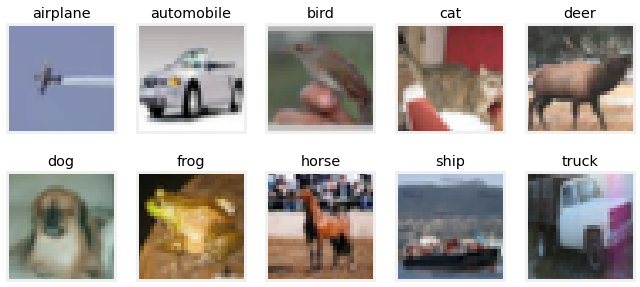

In [6]:
# plotting some random 10 images

batch_size = 32
num_classes = 10
epochs = 120

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [7]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Building the CNN Model 

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [9]:
#Compliling Model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the input image
x_train /= 255
x_test /= 255

# Training the model
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_train, y_train),
              validation_split = 0.2,
              shuffle=True)

Epoch 1/120
1250/1250 [==============================] - 41s 23ms/step - loss: 3.7972 - accuracy: 0.3409 - val_loss: 3.0261 - val_accuracy: 0.4535
Epoch 2/120
1250/1250 [==============================] - 26s 21ms/step - loss: 2.6883 - accuracy: 0.4744 - val_loss: 2.2570 - val_accuracy: 0.5383
Epoch 3/120
1250/1250 [==============================] - 27s 21ms/step - loss: 2.0430 - accuracy: 0.5500 - val_loss: 1.7270 - val_accuracy: 0.6037
Epoch 4/120
1250/1250 [==============================] - 26s 21ms/step - loss: 1.6419 - accuracy: 0.6050 - val_loss: 1.3969 - val_accuracy: 0.6567
Epoch 5/120
1250/1250 [==============================] - 26s 21ms/step - loss: 1.3851 - accuracy: 0.6433 - val_loss: 1.1768 - val_accuracy: 0.6981
Epoch 6/120
1250/1250 [==============================] - 26s 21ms/step - loss: 1.2266 - accuracy: 0.6701 - val_loss: 1.2010 - val_accuracy: 0.6679
Epoch 7/120
1250/1250 [==============================] - 26s 21ms/step - loss: 1.1236 - accuracy: 0.6906 - val_loss: 1

In [10]:
#Printing the accuracy for Model
accuracy = model.evaluate(x_test,y_test,verbose = 1)
print('Accuracy for CNN is :',accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 0.8984 - accuracy: 0.8393
Accuracy for CNN is : [0.8983873128890991, 0.8392999768257141]


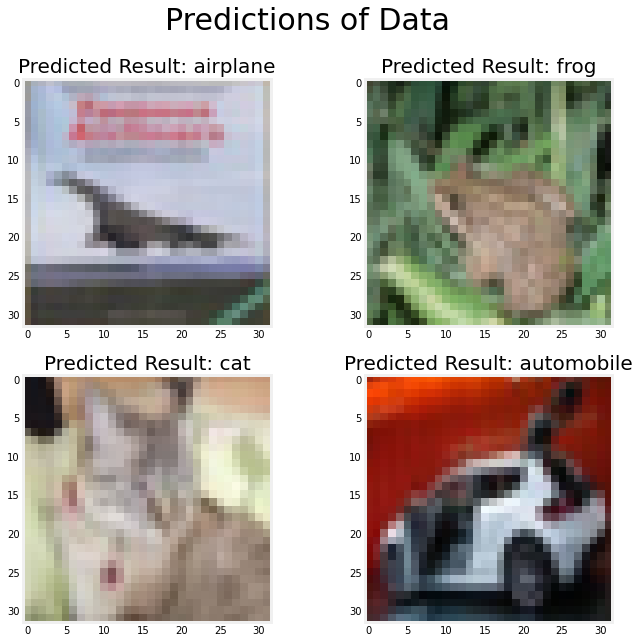

In [14]:
# Checking the predictions
predictions = model.predict(x_test)

plt.figure(figsize=[10,10])

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.subplot(2,2,1)
n = 3
plt.imshow((x_test[n]*255).reshape(32, 32, -1).astype(np.uint8), cmap=plt.cm.binary)
plt.title("Predicted Result: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False) 

plt.subplot(2,2,2)
n = 4
plt.imshow((x_test[n]*255).reshape(32, 32, -1).astype(np.uint8), cmap=plt.cm.binary)
plt.title("Predicted Result: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2,2,3)
n = 8
plt.imshow((x_test[n]*255).reshape(32, 32, -1).astype(np.uint8), cmap=plt.cm.binary)
plt.title("Predicted Result: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.subplot(2,2,4)
n = 6
plt.imshow((x_test[n]*255).reshape(32, 32, -1).astype(np.uint8), cmap=plt.cm.binary)
plt.title("Predicted Result: " + str(class_names[np.argmax(predictions[n], axis=0)]), size=20)
plt.grid(False)

plt.suptitle("Predictions of Data", size=30, color="black")

plt.show()

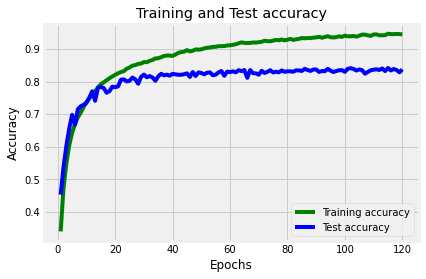

In [12]:
#Plotting Train and Test Accuracy for each epoch
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,121)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

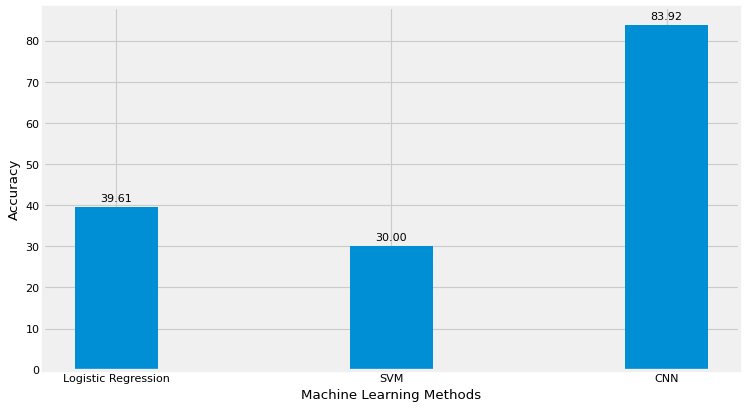

In [20]:
#Comparing different accuracies
#Since we have different ipynb notebooks for different models we are getting the values hard coded in accuracies list for plotting the graph.
tags = ['Logistic Regression','SVM', 'CNN']
accuracies = [39.61,30,83.92]
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(tags,accuracies,align='center', width=0.3)
plt.xlabel('Machine Learning Methods')
plt.ylabel('Accuracy')
# zip joins x and y coordinates in pairs
for x,y in zip(tags,accuracies):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()